# Project 1: JPEG Compression - ELEC 5306

This file is the template for Project 1.

Please follow the instruction, code and text where it is required, and run through this file.

The original code is forked from a well-developed repo: https://github.com/ghallak/jpeg-python.

In [ ]:
# get the test image for this project
!wget https://www.dropbox.com/s/hxizjdkqw2s0mth/download.png?dl=0 -O airplane.png
!wget -O page.png https://www.dropbox.com/scl/fi/7lzrce83hxka0qk61219l/page5306.png?rlkey=grtyrnaj3qh32lveoqtannnw0&dl=0

--2024-03-29 04:00:49--  https://www.dropbox.com/s/hxizjdkqw2s0mth/download.png?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6057:18::a27d:d12
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/hxizjdkqw2s0mth/download.png [following]
--2024-03-29 04:00:49--  https://www.dropbox.com/s/raw/hxizjdkqw2s0mth/download.png
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb7d910549b121656dd18dc8768.dl.dropboxusercontent.com/cd/0/inline/CP8fahk6upNK8QTnq3zHVSxJKGdTB8glqgcfDlo4ZOCzA5IGkxqphHsoCIVwxKch1BIX89WAkicIGRolxJTxt9Nbv9qgrejIhnDBTaR7iYecdfRipyUCt10dRfoDjhdhkpHnHE60vRqS04A3hftPusOz/file# [following]
--2024-03-29 04:00:49--  https://ucb7d910549b121656dd18dc8768.dl.dropboxusercontent.com/cd/0/inline/CP8fahk6upNK8QTnq3zHVSxJKGdTB8glqgcfDlo4ZOCzA5IGkxqphHsoCIVwxKch1BIX89WAkicIGRolxJTxt9Nbv9qgrejIh

In [ ]:
import numpy as np
from PIL import Image
i = Image.open('airplane.png')
i = np.array(i)

inew = Image.open("page.png")
# make the image reain the 3 channenls (RGB) only
inew = inew.resize((512,512)).convert('RGB').save("page.png","PNG")
j = Image.open('page.png')
j = np.array(j)

In [ ]:
i.shape

(512, 512, 3)

In [ ]:
j.shape

(512, 512, 3)

In [ ]:
##########################
# RUN THIS CELL
# NO MODIFICATION REQUIRED
##########################

import argparse
import os
import sys
import math
import numpy as np

from scipy import fftpack
from PIL import Image


In [ ]:
##########################
# RUN THIS CELL
# NO MODIFICATION REQUIRED
##########################

# This cell defines a HuffmanTree class

from queue import PriorityQueue


class HuffmanTree:

    class __Node:
        def __init__(self, value, freq, left_child, right_child):
            self.value = value
            self.freq = freq
            self.left_child = left_child
            self.right_child = right_child

        @classmethod
        def init_leaf(self, value, freq):
            return self(value, freq, None, None)

        @classmethod
        def init_node(self, left_child, right_child):
            freq = left_child.freq + right_child.freq
            return self(None, freq, left_child, right_child)

        def is_leaf(self):
            return self.value is not None

        def __eq__(self, other):
            stup = self.value, self.freq, self.left_child, self.right_child
            otup = other.value, other.freq, other.left_child, other.right_child
            return stup == otup

        def __nq__(self, other):
            return not (self == other)

        def __lt__(self, other):
            return self.freq < other.freq

        def __le__(self, other):
            return self.freq < other.freq or self.freq == other.freq

        def __gt__(self, other):
            return not (self <= other)

        def __ge__(self, other):
            return not (self < other)

    def __init__(self, arr):
        q = PriorityQueue()

        # calculate frequencies and insert them into a priority queue
        for val, freq in self.__calc_freq(arr).items():
            q.put(self.__Node.init_leaf(val, freq))

        while q.qsize() >= 2:
            u = q.get()
            v = q.get()

            q.put(self.__Node.init_node(u, v))

        self.__root = q.get()

        # dictionaries to store huffman table
        self.__value_to_bitstring = dict()

    def value_to_bitstring_table(self):
        if len(self.__value_to_bitstring.keys()) == 0:
            self.__create_huffman_table()
        return self.__value_to_bitstring

    def __create_huffman_table(self):
        def tree_traverse(current_node, bitstring=''):
            if current_node is None:
                return
            if current_node.is_leaf():
                self.__value_to_bitstring[current_node.value] = bitstring
                return
            tree_traverse(current_node.left_child, bitstring + '0')
            tree_traverse(current_node.right_child, bitstring + '1')

        tree_traverse(self.__root)

    def __calc_freq(self, arr):
        freq_dict = dict()
        for elem in arr:
            if elem in freq_dict:
                freq_dict[elem] += 1
            else:
                freq_dict[elem] = 1
        return freq_dict


In [ ]:
##########################
# RUN THIS CELL
# NO MODIFICATION REQUIRED
##########################

# This cell contains necessary functions for encoding

import numpy as np


def zigzag_points(rows, cols):
    # constants for directions
    UP, DOWN, RIGHT, LEFT, UP_RIGHT, DOWN_LEFT = range(6)

    # move the point in different directions
    def move(direction, point):
        return {
            UP: lambda point: (point[0] - 1, point[1]),
            DOWN: lambda point: (point[0] + 1, point[1]),
            LEFT: lambda point: (point[0], point[1] - 1),
            RIGHT: lambda point: (point[0], point[1] + 1),
            UP_RIGHT: lambda point: move(UP, move(RIGHT, point)),
            DOWN_LEFT: lambda point: move(DOWN, move(LEFT, point))
        }[direction](point)

    # return true if point is inside the block bounds
    def inbounds(point):
        return 0 <= point[0] < rows and 0 <= point[1] < cols

    # start in the top-left cell
    point = (0, 0)

    # True when moving up-right, False when moving down-left
    move_up = True

    for i in range(rows * cols):
        yield point
        if move_up:
            if inbounds(move(UP_RIGHT, point)):
                point = move(UP_RIGHT, point)
            else:
                move_up = False
                if inbounds(move(RIGHT, point)):
                    point = move(RIGHT, point)
                else:
                    point = move(DOWN, point)
        else:
            if inbounds(move(DOWN_LEFT, point)):
                point = move(DOWN_LEFT, point)
            else:
                move_up = True
                if inbounds(move(DOWN, point)):
                    point = move(DOWN, point)
                else:
                    point = move(RIGHT, point)


def bits_required(n):
    n = abs(n)
    result = 0
    while n > 0:
        n >>= 1
        result += 1
    return result


def binstr_flip(binstr):
    # check if binstr is a binary string
    if not set(binstr).issubset('01'):
        raise ValueError("binstr should have only '0's and '1's")
    return ''.join(map(lambda c: '0' if c == '1' else '1', binstr))


def uint_to_binstr(number, size):
    return bin(number)[2:][-size:].zfill(size)


def int_to_binstr(n):
    if n == 0:
        return ''

    binstr = bin(abs(n))[2:]

    # change every 0 to 1 and vice verse when n is negative
    return binstr if n > 0 else binstr_flip(binstr)


def flatten(lst):
    return [item for sublist in lst for item in sublist]


def block_to_zigzag(block):
    return np.array([block[point] for point in zigzag_points(*block.shape)])


def write_to_file(filepath, dc, ac, blocks_count, tables):
    try:
        f = open(filepath, 'w')
    except FileNotFoundError as e:
        raise FileNotFoundError(
                "No such directory: {}".format(
                    os.path.dirname(filepath))) from e

    for table_name in ['dc_y', 'ac_y', 'dc_c', 'ac_c']:

        # 16 bits for 'table_size'
        f.write(uint_to_binstr(len(tables[table_name]), 16))

        for key, value in tables[table_name].items():
            if table_name in {'dc_y', 'dc_c'}:
                # 4 bits for the 'category'
                # 4 bits for 'code_length'
                # 'code_length' bits for 'huffman_code'
                f.write(uint_to_binstr(key, 4))
                f.write(uint_to_binstr(len(value), 4))
                f.write(value)
            else:
                # 4 bits for 'run_length'
                # 4 bits for 'size'
                # 8 bits for 'code_length'
                # 'code_length' bits for 'huffman_code'
                f.write(uint_to_binstr(key[0], 4))
                f.write(uint_to_binstr(key[1], 4))
                f.write(uint_to_binstr(len(value), 8))
                f.write(value)

    # 32 bits for 'blocks_count'
    f.write(uint_to_binstr(blocks_count, 32))

    for b in range(blocks_count):
        for c in range(3):
            category = bits_required(dc[b, c])
            symbols, values = run_length_encode(ac[b, :, c])

            dc_table = tables['dc_y'] if c == 0 else tables['dc_c']
            ac_table = tables['ac_y'] if c == 0 else tables['ac_c']

            f.write(dc_table[category])
            f.write(int_to_binstr(dc[b, c]))

            for i in range(len(symbols)):
                f.write(ac_table[tuple(symbols[i])])
                f.write(values[i])
    f.close()


In [ ]:
##########################
# RUN THIS CELL
# NO MODIFICATION REQUIRED
##########################

# This cell contains necessary functions for encoding

class JPEGFileReader:
    TABLE_SIZE_BITS = 16
    BLOCKS_COUNT_BITS = 32

    DC_CODE_LENGTH_BITS = 4
    CATEGORY_BITS = 4

    AC_CODE_LENGTH_BITS = 8
    RUN_LENGTH_BITS = 4
    SIZE_BITS = 4

    def __init__(self, filepath):
        self.__file = open(filepath, 'r')

    def read_int(self, size):
        if size == 0:
            return 0

        # the most significant bit indicates the sign of the number
        bin_num = self.__read_str(size)
        if bin_num[0] == '1':
            return self.__int2(bin_num)
        else:
            return self.__int2(binstr_flip(bin_num)) * -1

    def read_dc_table(self):
        table = dict()

        table_size = self.__read_uint(self.TABLE_SIZE_BITS)
        for _ in range(table_size):
            category = self.__read_uint(self.CATEGORY_BITS)
            code_length = self.__read_uint(self.DC_CODE_LENGTH_BITS)
            code = self.__read_str(code_length)
            table[code] = category
        return table

    def read_ac_table(self):
        table = dict()

        table_size = self.__read_uint(self.TABLE_SIZE_BITS)
        for _ in range(table_size):
            run_length = self.__read_uint(self.RUN_LENGTH_BITS)
            size = self.__read_uint(self.SIZE_BITS)
            code_length = self.__read_uint(self.AC_CODE_LENGTH_BITS)
            code = self.__read_str(code_length)
            table[code] = (run_length, size)
        return table

    def read_blocks_count(self):
        return self.__read_uint(self.BLOCKS_COUNT_BITS)

    def read_huffman_code(self, table):
        prefix = ''
        # TODO: break the loop if __read_char is not returing new char
        while prefix not in table:
            prefix += self.__read_char()
        return table[prefix]

    def __read_uint(self, size):
        if size <= 0:
            raise ValueError("size of unsigned int should be greater than 0")
        return self.__int2(self.__read_str(size))

    def __read_str(self, length):
        return self.__file.read(length)

    def __read_char(self):
        return self.__read_str(1)

    def __int2(self, bin_num):
        return int(bin_num, 2)


def read_image_file(filepath):
    reader = JPEGFileReader(filepath)

    tables = dict()
    for table_name in ['dc_y', 'ac_y', 'dc_c', 'ac_c']:
        if 'dc' in table_name:
            tables[table_name] = reader.read_dc_table()
        else:
            tables[table_name] = reader.read_ac_table()

    blocks_count = reader.read_blocks_count()

    dc = np.empty((blocks_count, 3), dtype=np.int32)
    ac = np.empty((blocks_count, 63, 3), dtype=np.int32)

    for block_index in range(blocks_count):
        for component in range(3):
            dc_table = tables['dc_y'] if component == 0 else tables['dc_c']
            ac_table = tables['ac_y'] if component == 0 else tables['ac_c']

            category = reader.read_huffman_code(dc_table)
            dc[block_index, component] = reader.read_int(category)

            cells_count = 0

            # TODO: try to make reading AC coefficients better
            while cells_count < 63:
                run_length, size = reader.read_huffman_code(ac_table)

                if (run_length, size) == (0, 0):
                    while cells_count < 63:
                        ac[block_index, cells_count, component] = 0
                        cells_count += 1
                else:
                    for i in range(run_length):
                        ac[block_index, cells_count, component] = 0
                        cells_count += 1
                    if size == 0:
                        ac[block_index, cells_count, component] = 0
                    else:
                        value = reader.read_int(size)
                        ac[block_index, cells_count, component] = value
                    cells_count += 1

    return dc, ac, tables, blocks_count


def zigzag_to_block(zigzag):
    # assuming that the width and the height of the block are equal
    rows = cols = int(math.sqrt(len(zigzag)))

    if rows * cols != len(zigzag):
        raise ValueError("length of zigzag should be a perfect square")

    block = np.empty((rows, cols), np.int32)

    for i, point in enumerate(zigzag_points(rows, cols)):
        block[point] = zigzag[i]

    return block


def dequantize(block, component):
    q = load_quantization_table(component)
    return block * q


def idct_2d(image):
    return fftpack.idct(fftpack.idct(image.T, norm='ortho').T, norm='ortho')


## Q1: 2D discrete cosine transform

**TARGET**: Re-implement the 2D DCT `fftpack.dct(x, type=2, norm='ortho)`

**REFERENCE**: Type II in https://docs.scipy.org/doc/scipy/reference/generated/scipy.fftpack.dct.html

**EXAMPLE**: Here is an example for re-implementing `fftpack.dct(x, type=1, norm=None)` and validation.

In [ ]:
##########################
# RUN THIS CELL
# NO MODIFICATION REQUIRED
##########################

# Example of a 2D DCT

def dct_2d_type_1_norm_none(image):

    def vec_cos(k, N):
        return np.cos((math.pi * k * np.arange(1, N-1)) / (N - 1))

    yk = np.zeros_like(image).astype(np.float32)
    for row, row_img in enumerate(image):
        vec_xn = row_img.astype(np.float32)
        vec_yk = np.zeros_like(vec_xn)
        for k in range(len(vec_yk)):
            vec_yk[k] = vec_xn[0] + (-1) ** k * vec_xn[-1] + 2 * np.sum(vec_xn[1:-1] * vec_cos(k, len(vec_xn)))
        yk[row] = vec_yk

    return yk

rnd_img = np.random.randint(0, 256, size=(4, 4))

print(fftpack.dct(rnd_img, type=1))
print(dct_2d_type_1_norm_none(rnd_img))

[[ 260.  -59.    5. -104.]
 [1004.  -35. -175.  112.]
 [1183.    2. -140.   29.]
 [ 770.  279.   23. -258.]]
[[ 260.  -59.    5. -104.]
 [1004.  -35. -175.  112.]
 [1183.    2. -140.   29.]
 [ 770.  279.   23. -258.]]


### Solution:

Write your code below

In [ ]:
##########################
# !!!!!!!!! EDIT REQUIRED !!!!!!!!!!
##########################

# Complete this function
def dct_2d_type_2_norm_ortho(image):

  # Create the cosine function
  def vec_cos(k, N):
      # np.arange(0, N) represents "n" in the mathematical formula
      return np.cos((math.pi * k * (2*np.arange(0, N) + 1)) / (2 * N))
  #Initialize a zero array with the same shape for the input image.
  yk = np.zeros_like(image).astype(np.float32)

  for row, row_img in enumerate(image):
        vec_xn = row_img.astype(np.float32)
        vec_yk = np.zeros_like(vec_xn)
        for k in range(len(vec_yk)):
            vec_yk[k] = 2 * np.sum(vec_xn * vec_cos(k, len(vec_xn)))
            if k == 0:
                yk[row,k] = vec_yk[k] * np.sqrt(1 / (4*len(vec_xn)))
            else:
                yk[row,k] = vec_yk[k] * np.sqrt(1 / (2*len(vec_xn)))

  return yk



# for validation
# 1. define a image w/ random content
rnd_img = np.random.randint(0, 256, size=(4, 4))
# 2. get result from the original function
print(fftpack.dct(rnd_img, norm='ortho'))
# 3. get result from your written function
print(dct_2d_type_2_norm_ortho(rnd_img))
# 4. compare the output and check if they're the same

[[396.           0.          44.           0.        ]
 [362.         -21.41900706 -31.         -20.35254619]
 [173.          85.48838632  -4.         -86.28288245]
 [324.         -71.2269124   56.         -38.6875555 ]]
[[ 3.9600000e+02  0.0000000e+00  4.4000000e+01 -5.0242959e-14]
 [ 3.6200000e+02 -2.1419006e+01 -3.1000002e+01 -2.0352547e+01]
 [ 1.7300000e+02  8.5488388e+01 -4.0000000e+00 -8.6282883e+01]
 [ 3.2400000e+02 -7.1226913e+01  5.6000000e+01 -3.8687557e+01]]


If you cannot implement the function, use the offical dct function for later questions.

In [ ]:
##########################
# RUN THIS CELL
# NO MODIFICATION REQUIRED
##########################

# this cell defines a dct_2d function for the image, and is based on your function

def dct_2d(image):
  return dct_2d_type_2_norm_ortho(dct_2d_type_2_norm_ortho(image.T).T)

# if cannot figure out the dct function, uncomment below

# def dct_2d(image):
#  return fftpack.dct(fftpack.dct(image.T, norm='ortho').T, norm='ortho')

## Q2: run-length coding

In [ ]:
##########################
# RUN THIS CELL
# NO MODIFICATION REQUIRED
##########################

# this cell defines a run length encoder

def run_length_encode(arr):
    # determine where the sequence is ending prematurely
    last_nonzero = -1
    for i, elem in enumerate(arr):
        if elem != 0:
            last_nonzero = i

    symbols = []

    values = []

    run_length = 0

    for i, elem in enumerate(arr):
        if i > last_nonzero:
            symbols.append((0, 0))
            values.append(int_to_binstr(0))
            break
        elif elem == 0 and run_length < 15:
            run_length += 1
        else:
            size = bits_required(elem)
            symbols.append((run_length, size))
            values.append(int_to_binstr(elem))
            run_length = 0
    return symbols, values

arr = np.random.randint(0, 15, size=(16,))
ss, vv = run_length_encode(arr)
print('original array: {}\n symbols: {}\n values: {}\n'.format(arr, ss, vv))

original array: [ 1  9  6  1 12 12  2  9  9  5  9  5  8 12 14  0]
 symbols: [(0, 1), (0, 4), (0, 3), (0, 1), (0, 4), (0, 4), (0, 2), (0, 4), (0, 4), (0, 3), (0, 4), (0, 3), (0, 4), (0, 4), (0, 4), (0, 0)]
 values: ['1', '1001', '110', '1', '1100', '1100', '10', '1001', '1001', '101', '1001', '101', '1000', '1100', '1110', '']



**TARGET**:
1. Explain the meaning of items of `symbols` and `values` that are returned by `run_length_encode` below.
2. Figure out the original array. The `symbols` of this array is:

```
[(0, 2), (0, 3), (1, 2), (0, 2), (0, 2), (2, 2), (0, 3), (0, 1), (0, 1), (1, 1), (0, 1), (0, 1), (1, 1), (0, 2), (0, 2), (0, 3), (0, 3), (0, 2), (0, 2), (0, 2), (0, 3), (0, 2), (1, 2), (0, 2), (0, 2), (0, 2)]
```
And the `values` of this array is :
```
['10', '100', '11', '10', '10', '11', '100', '1', '1', '1', '1', '1', '1', '11', '10', '100', '100', '11', '11', '10', '100', '11', '11', '11', '10', '11']
```

### Solution:

1.The symbol consists of the tuples. Each tuple has 2 elements: The first element indicates the number of 0 before the current non-zero number. The second element represents how many binary digits are required to store the current number.
For the values, they express the originl values in binary terms.

2.Original array: [2 4 0 3 2 2 0 0 3 4 1 1 0 1 1 1 0 1 3 2 4 4 3 3 2 4 3 0 3 3 2 3]

## Q3: Arithmetic Coding

**TARGET**: Given the source alphabet Х = {C, E, L, #} and probability function P = {P(C), P(E), P(L), P(#)} = {0.5, 0.2, 0.2, 0.1}. Encode the sequence “ELEC#” with Arithmetic coding. Calculate the encoding output in binary form (i.e. 0.1011001...). Provide the result with your full calculation process.

Please refer to the following link and use the demonstrated approach: https://www.youtube.com/watch?v=7vfqhoJVwuc

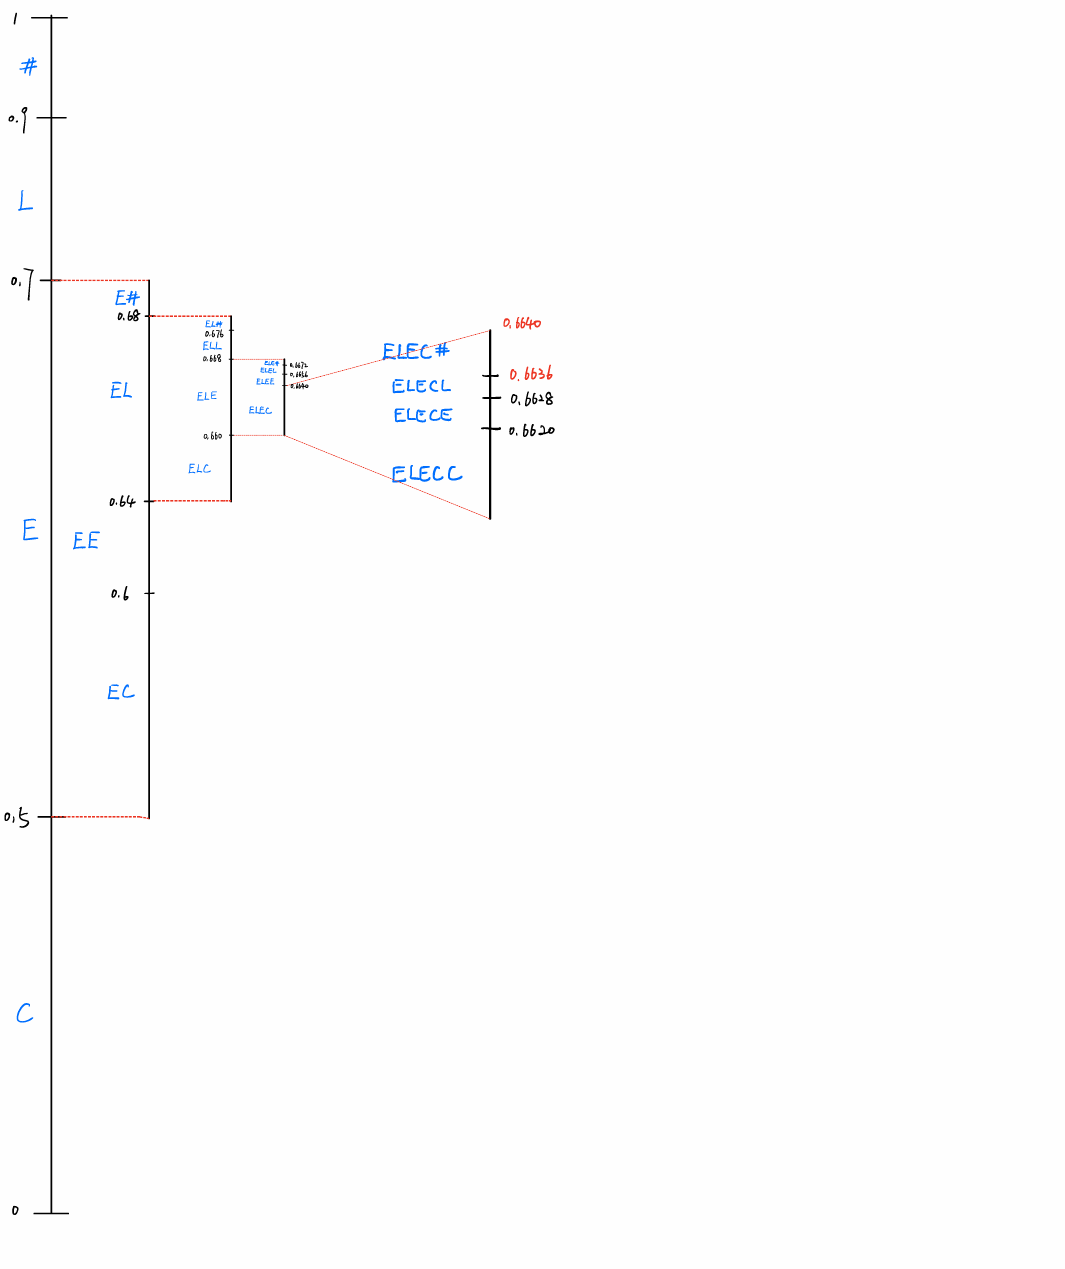

#### Answer:
 First we need to find the probability interval of "ELEC#". Then use an exact binary number to express this interval. Bisect the probability of 0-1 until the interval is exactly within the probability interval of ELEC#. After this, the compression is complete.

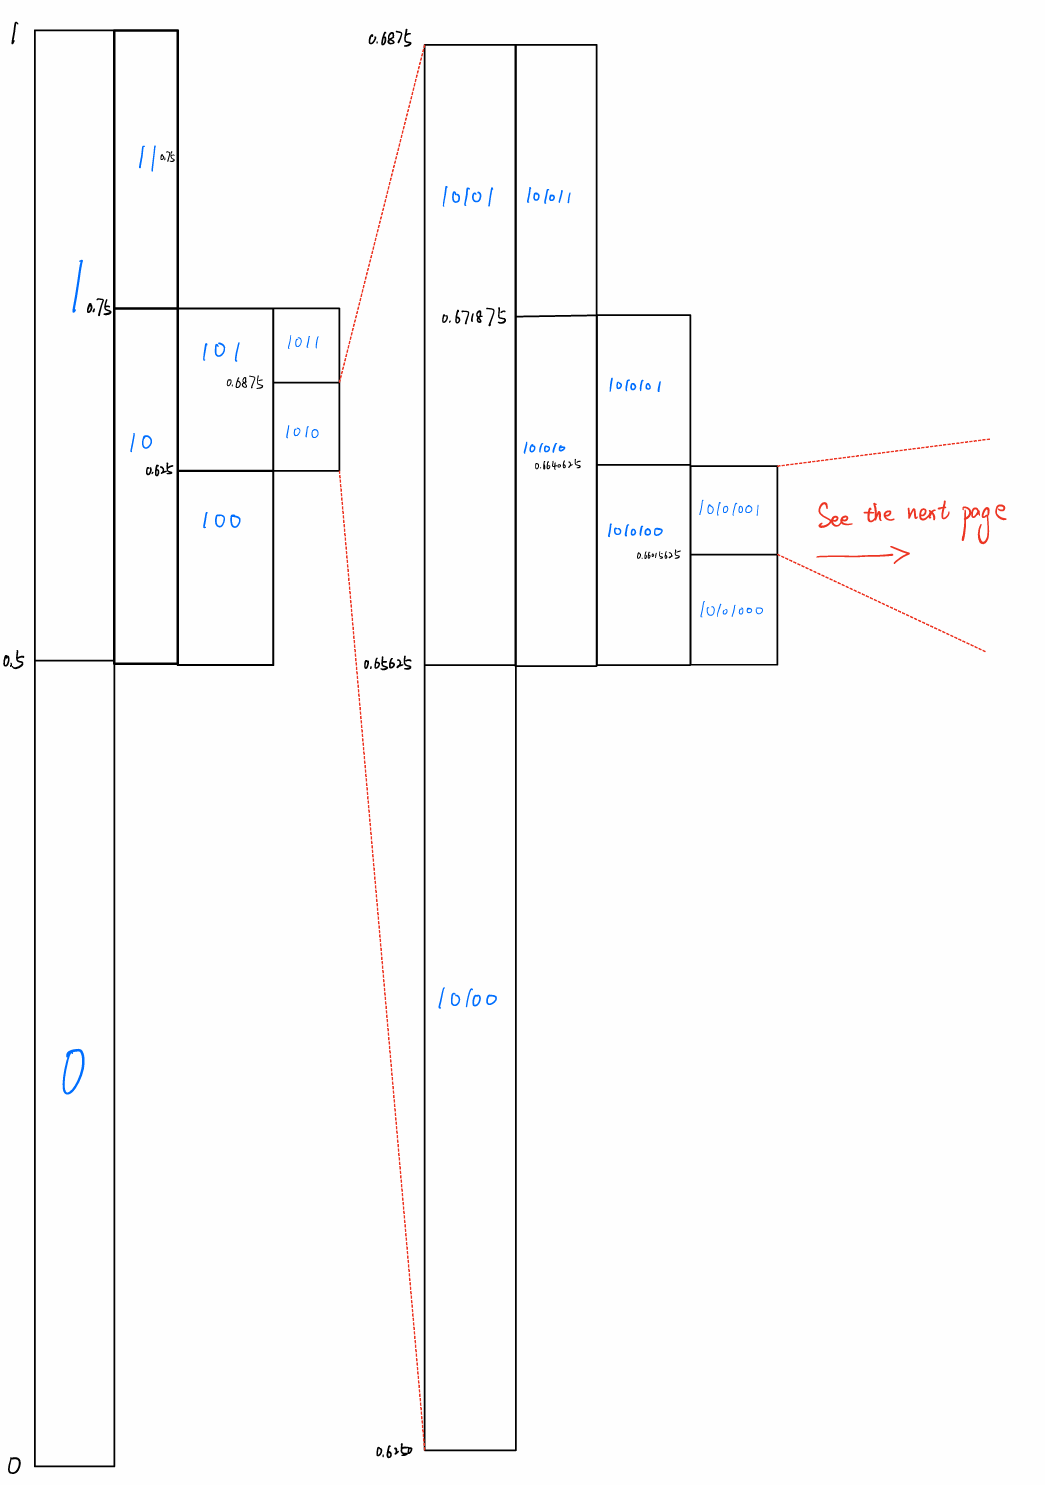

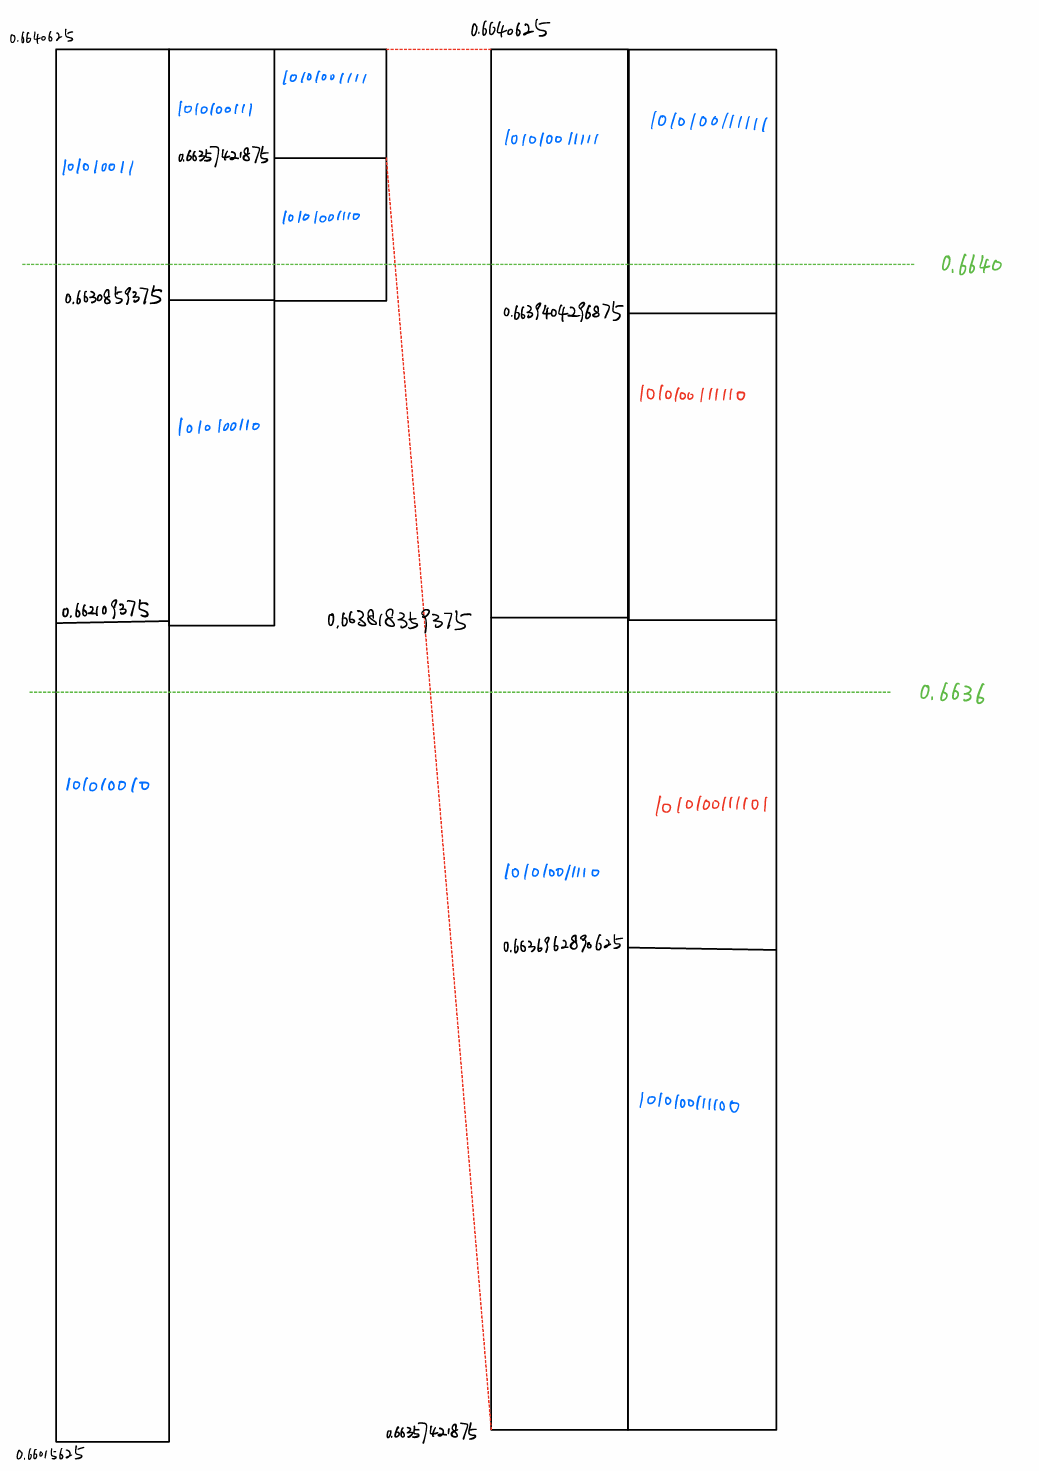

### Solution:


In [ ]:
"""
First, we need to find the probability of ELEC# in the range of 0-1.
"""

# Set the range of probaility function
current_max = 1
current_min = 0

for i in "ELEC#":
    if i == "C":
        # The probability of C
        letter_max = 0.5
        letter_min = 0
        # Copy a set of data for calculating the new range of maximum and minimum
        new_max = current_max
        new_min = current_min
        bound = new_max - new_min
        # Calulation
        current_max = new_max - bound*(1- letter_max)
        current_min = new_max - bound*(1- letter_min)
    elif i == "E":
        # Same logic as "C"
        letter_max = 0.7
        letter_min = 0.5

        new_max = current_max
        new_min = current_min
        bound = new_max - new_min

        current_max = new_max - bound*(1- letter_max)
        current_min = new_max - bound*(1- letter_min)

    elif i == "L":
        # Same logic as "C"
        letter_max = 0.9
        letter_min = 0.7

        new_max = current_max
        new_min = current_min
        bound = new_max - new_min

        current_max = new_max - bound*(1- letter_max)
        current_min = new_max - bound*(1- letter_min)

    elif i == "#":
        # Same logic as "C"
        letter_max = 1
        letter_min = 0.9

        new_max = current_max
        new_min = current_min
        bound = new_max - new_min

        current_max = new_max - bound*(1- letter_max)
        current_min = new_max - bound*(1- letter_min)

ELEC_max = current_max
ELEC_min = current_min

print(f"The probability of ELEC# is from {ELEC_min} to {ELEC_max:.4f}")
"""
Second, we need to find the binary encoding of the range
"""

form = []  # A list for storing binary codes
max = 1
min = 0
middle = 0.5

"""
In the 2.1 step, we find the same part of binary encoding. At this time,
the binary encoding represents the range just covering the range of ELEC#,
and any binary encoding will make middle enter the probability range again.
"""

while middle > ELEC_max or middle < ELEC_min:
    if middle > ELEC_max:
        form.append(0)
        max = middle
        min = min
        middle = (max + min)/2
    elif middle < ELEC_min:
        form.append(1)
        max = max
        min = middle
        middle = (max + min)/2


# print(form)
# print(min,max)
# In this time, it just meets the binary encoding just covering the range.
middle = (max+min)/2

"""
In the 2.2 step, we find the lowwer and upper bound of binary encoding.
Which means, when the middle of the lowwer and upper bound enter the
probability range again, it meets the condition that both sides are
within the ELEC range, and the value stops.
The obtained is the required binary encode.
"""
# copy the form list
form_min = form.copy()
form_max = form.copy()

# LOWER BOUND
form_min.append(1)
middle_low = middle

# Continue the binary encoding until the middle value is greater than
# or equal to the minimum probality.
while middle_low < ELEC_min:
    form_min.append(1)
    middle_low = (middle_low + 1)/2

# We get the minimum binary encoding
form_min.append(0)

# UPPER BOUND
form_max.append(0)
middle_high = middle

# Continue the binary encoding until the middle value is less than
# or equal to the maximum probality.
while middle_high > ELEC_max:
    form_max.append(0)
    middle_high = (middle_high + 1)/2
# We get the maximum binary encoding
form_max.append(1)

print(f"The binary encoding is from {form_max} to {form_min}")

The probability of ELEC# is from 0.6636 to 0.6640
The binary encoding is from [1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1] to [1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0]


## Q4: Quantization table

**TARGET**:
1. The matrix is a quantization table of the JPEG compression algorithm. After applying the DCT of the image, the result will be divided by the quantization table, and then rounded to the nearest integer. This step can compresses the image. The larger the numbers in the quantization table, the greater the division coefficients for the DCT. This can be increase the compression effect, but it also reduce the accuracy of the image. FOr the humans' eyes, this may appear as some detail being lost.
2. Given the human eye's varying sensitivity to spatial frequencies, explain why the quantization table adopts a progressive increase in scalar values from the top-left to the bottom-right corners.
3. Design a quantization table that causes no loss in information in this quantization step given the coefficients from DCT are all integers.

In [ ]:

def load_quantization_table(component):
    # Quantization Table for: Photoshop - (Save For Web 080)
    # (http://www.impulseadventure.com/photo/jpeg-quantization.html)
    if component == 'lum':
        q = np.array([[2, 2, 2, 2, 3, 4, 5, 6],
                      [2, 2, 2, 2, 3, 4, 5, 6],
                      [2, 2, 2, 2, 4, 5, 7, 9],
                      [2, 2, 2, 4, 5, 7, 9, 12],
                      [3, 3, 4, 5, 8, 10, 12, 12],
                      [4, 4, 5, 7, 10, 12, 12, 12],
                      [5, 5, 7, 9, 12, 12, 12, 12],
                      [6, 6, 9, 12, 12, 12, 12, 12]])
    elif component == 'chrom':
        q = np.array([[3, 3, 5, 9, 13, 15, 15, 15],
                      [3, 4, 6, 11, 14, 12, 12, 12],
                      [5, 6, 9, 14, 12, 12, 12, 12],
                      [9, 11, 14, 12, 12, 12, 12, 12],
                      [13, 14, 12, 12, 12, 12, 12, 12],
                      [15, 12, 12, 12, 12, 12, 12, 12],
                      [15, 12, 12, 12, 12, 12, 12, 12],
                      [15, 12, 12, 12, 12, 12, 12, 12]])
    else:
        raise ValueError((
            "component should be either 'lum' or 'chrom', "
            "but '{comp}' was found").format(comp=component))

    return q


def quantize(block, component):
    q = load_quantization_table(component)
    return (block / q).round().astype(np.int32)


### Solution:

1. The matrix is a quantization table of the JPEG compression algorithm. After applying the DCT of the image, the result will be divided by the quantization table, and then rounded to the nearest integer. This step can compresses the image. The larger the numbers in the quantization table, the greater the division coefficients for the DCT. This can be increase the compression effect, but it also reduce the accuracy of the image. FOr the humans' eyes, this may appear as some detail being lost.

2. Overall, no matter lum or chromium, humans eyes are more sensitive to low-frequency information. The quantization table is designed to gradually increase its values from the upper left corner to the lower right corner, which preserves more low-frequency information.  As a result, the image quality does not be significantly reduced when viewed by the humans eyes. At the same time, more high-frequency information is compressed. This compresses the image space more. It is a clever balance between image quality and space compression.

3. If all DCT coefficients are integers, as long as all elements in the quantization table are kept as 1. The DCT coefficients will not be changed due to calculation. This approach can achieve no loss quantization of information.

In [ ]:
##########################
# RUN THIS CELL
# NO MODIFICATION REQUIRED
##########################

# this cell defines the main function for encoding

def encode(input_file, output_file):

    image = Image.open(input_file)
    ycbcr = image.convert('YCbCr')

    npmat = np.array(ycbcr, dtype=np.uint8)

    rows, cols = npmat.shape[0], npmat.shape[1]

    # block size: 8x8
    if rows % 8 == cols % 8 == 0:
        blocks_count = rows // 8 * cols // 8
    else:
        raise ValueError(("the width and height of the image "
                          "should both be mutiples of 8"))

    # dc is the top-left cell of the block, ac are all the other cells
    dc = np.empty((blocks_count, 3), dtype=np.int32)
    ac = np.empty((blocks_count, 63, 3), dtype=np.int32)

    for i in range(0, rows, 8):
        for j in range(0, cols, 8):
            try:
                block_index += 1
            except NameError:
                block_index = 0

            for k in range(3):
                # split 8x8 block and center the data range on zero
                # [0, 255] --> [-128, 127]
                block = npmat[i:i+8, j:j+8, k] - 128

                dct_matrix = dct_2d(block)
                quant_matrix = quantize(dct_matrix,
                                        'lum' if k == 0 else 'chrom')
                zz = block_to_zigzag(quant_matrix)

                dc[block_index, k] = zz[0]
                ac[block_index, :, k] = zz[1:]

    H_DC_Y = HuffmanTree(np.vectorize(bits_required)(dc[:, 0]))
    H_DC_C = HuffmanTree(np.vectorize(bits_required)(dc[:, 1:].flat))
    H_AC_Y = HuffmanTree(
            flatten(run_length_encode(ac[i, :, 0])[0]
                    for i in range(blocks_count)))
    H_AC_C = HuffmanTree(
            flatten(run_length_encode(ac[i, :, j])[0]
                    for i in range(blocks_count) for j in [1, 2]))

    tables = {'dc_y': H_DC_Y.value_to_bitstring_table(),
              'ac_y': H_AC_Y.value_to_bitstring_table(),
              'dc_c': H_DC_C.value_to_bitstring_table(),
              'ac_c': H_AC_C.value_to_bitstring_table()}

    write_to_file(output_file, dc, ac, blocks_count, tables)


In [ ]:
##########################
# RUN THIS CELL
# NO MODIFICATION REQUIRED
##########################

# this cell defines the main function for decoding

def decode(input_file, output_file):
    dc, ac, tables, blocks_count = read_image_file(input_file)

    # assuming that the block is a 8x8 square
    block_side = 8

    # assuming that the image height and width are equal
    image_side = int(math.sqrt(blocks_count)) * block_side

    blocks_per_line = image_side // block_side

    npmat = np.empty((image_side, image_side, 3), dtype=np.uint8)

    for block_index in range(blocks_count):
        i = block_index // blocks_per_line * block_side
        j = block_index % blocks_per_line * block_side

        for c in range(3):
            zigzag = [dc[block_index, c]] + list(ac[block_index, :, c])
            quant_matrix = zigzag_to_block(zigzag)
            dct_matrix = dequantize(quant_matrix, 'lum' if c == 0 else 'chrom')
            block = idct_2d(dct_matrix)
            npmat[i:i+8, j:j+8, c] = block + 128

    image = Image.fromarray(npmat, 'YCbCr')
    image = image.convert('RGB')
    display(image)

    image.save(output_file)

In [ ]:
encode('airplane.png', 'encoded.txt')

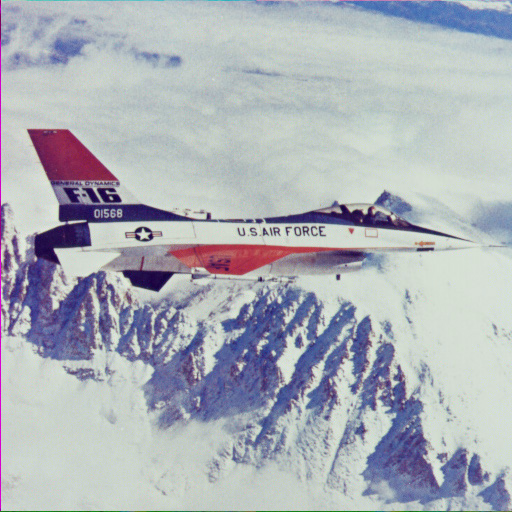

In [ ]:
decode('encoded.txt', 'decoded.png')

## Q5: PSNR

**TARGET**:
1. Define a function that calculates the PSNR of a pair of images, use the results from the above code blocks
2. Calculate the PSNR of the original image and the decoded image

### Solution:

In [ ]:
##########################
# !!!!!!!!! EDIT REQUIRED !!!!!!!!!!
##########################

def cal_psnr(original_image, target_image):
  # RMSE is sqrt of mse
  # MSE is mean of the square of each original element minus target elment
  rmse = np.sqrt(np.mean((original_image - target_image) ** 2))

  # PSNR = 20*log10(255/RMSE) in dB
  psnr = 20 * math.log10(255/rmse)

  return psnr

original_file = '/content/airplane.png'
decoded_file = '/content/decoded.png'

img_ori = Image.open(original_file)
img_doc = Image.open(decoded_file)

img_ori = np.array(img_ori, dtype=np.float32)
img_doc = np.array(img_doc, dtype=np.float32)

print('The PSNR of the decoded image against the original one is {}'.format(cal_psnr(img_ori, img_doc)))

The PSNR of the decoded image against the original one is 34.969686927707116


## Q6 Advanced Analysis
**TARGET**:
1. Design a theoretical quantization table that minimizes information loss for text-heavy images. Provide a justification for your design choices.
2. Propose a methodology for empirically evaluating the impact of different quantization tables on image quality and compression efficiency. This should include both objective metrics (e.g., PSNR, SSIM) and the protocols to evaluate your compressed image visually.
3. Use the method you proposed in the last question to evaluate your quantization table.

### Solution:

In [ ]:
def encode_new(input_file, output_file, quantize):

    image = Image.open(input_file)
    ycbcr = image.convert('YCbCr')

    npmat = np.array(ycbcr, dtype=np.uint8)

    rows, cols = npmat.shape[0], npmat.shape[1]

    # block size: 8x8
    if rows % 8 == cols % 8 == 0:
        blocks_count = rows // 8 * cols // 8
    else:
        raise ValueError(("the width and height of the image "
                          "should both be mutiples of 8"))

    # dc is the top-left cell of the block, ac are all the other cells
    dc = np.empty((blocks_count, 3), dtype=np.int32)
    ac = np.empty((blocks_count, 63, 3), dtype=np.int32)

    for i in range(0, rows, 8):
        for j in range(0, cols, 8):
            try:
                block_index += 1
            except NameError:
                block_index = 0

            for k in range(3):
                # split 8x8 block and center the data range on zero
                # [0, 255] --> [-128, 127]
                block = npmat[i:i+8, j:j+8, k] - 128

                dct_matrix = dct_2d(block)
                quant_matrix = quantize(dct_matrix,
                                        'lum' if k == 0 else 'chrom')
                zz = block_to_zigzag(quant_matrix)

                dc[block_index, k] = zz[0]
                ac[block_index, :, k] = zz[1:]

    H_DC_Y = HuffmanTree(np.vectorize(bits_required)(dc[:, 0]))
    H_DC_C = HuffmanTree(np.vectorize(bits_required)(dc[:, 1:].flat))
    H_AC_Y = HuffmanTree(
            flatten(run_length_encode(ac[i, :, 0])[0]
                    for i in range(blocks_count)))
    H_AC_C = HuffmanTree(
            flatten(run_length_encode(ac[i, :, j])[0]
                    for i in range(blocks_count) for j in [1, 2]))

    tables = {'dc_y': H_DC_Y.value_to_bitstring_table(),
              'ac_y': H_AC_Y.value_to_bitstring_table(),
              'dc_c': H_DC_C.value_to_bitstring_table(),
              'ac_c': H_AC_C.value_to_bitstring_table()}

    write_to_file(output_file, dc, ac, blocks_count, tables)

In [ ]:
def decode_new(input_file, output_file, dequantize):
    dc, ac, tables, blocks_count = read_image_file(input_file)

    # assuming that the block is a 8x8 square
    block_side = 8

    # assuming that the image height and width are equal
    image_side = int(math.sqrt(blocks_count)) * block_side

    blocks_per_line = image_side // block_side

    npmat = np.empty((image_side, image_side, 3), dtype=np.uint8)

    for block_index in range(blocks_count):
        i = block_index // blocks_per_line * block_side
        j = block_index % blocks_per_line * block_side

        for c in range(3):
            zigzag = [dc[block_index, c]] + list(ac[block_index, :, c])
            quant_matrix = zigzag_to_block(zigzag)
            dct_matrix = dequantize(quant_matrix, 'lum' if c == 0 else 'chrom')
            block = idct_2d(dct_matrix)
            npmat[i:i+8, j:j+8, c] = block + 128

    image = Image.fromarray(npmat, 'YCbCr')
    image = image.convert('RGB')
    display(image)

    image.save(output_file)

In [ ]:
from skimage.metrics import structural_similarity as ssim

def cal_ssim(original_image, target_image):
  """
  This function is use to calculate the SSIM between the original
  image and the compressed image.
  """
  SSIM, _ = ssim(original_image, target_image, full=True, win_size=3)

  return SSIM


In [ ]:
def cal_compression_rate(original_file, compressed_file):

  # get the size of original & compressed image
  original_size = os.path.getsize(original_file)
  compressed_size = os.path.getsize(compressed_file)
  # calculate the cpmpression rate
  compression_rate = ((original_size - compressed_size) / original_size) * 100

  return compression_rate



In [ ]:
def new1_quantization_table(component):
  # Quantization Table for: Photoshop - (Save For Web 080)
  # (http://www.impulseadventure.com/photo/jpeg-quantization.html)
  if component == 'lum':

      q = np.array([[2, 2, 2, 2, 3, 4, 1, 1],
              [2, 2, 2, 2, 3, 4, 1, 1],
              [2, 2, 2, 2, 4, 1, 1, 1],
              [2, 2, 2, 1, 1, 1, 1, 1],
              [3, 3, 1, 1, 1, 1, 1, 1],
              [4, 4, 5, 1, 1, 1, 1, 1],
              [5, 5, 1, 1, 1, 1, 1, 1],
              [6, 1, 1, 1, 1, 1, 1, 1]])
  elif component == 'chrom':
      q = np.array([[3, 3, 5, 9, 13, 15, 15, 15],
              [3, 4, 6, 11, 14, 12, 12, 12],
              [5, 6, 9, 14, 12, 12, 12, 12],
              [9, 11, 14, 12, 12, 12, 12, 12],
              [13, 14, 12, 12, 12, 12, 12, 12],
              [15, 12, 12, 12, 12, 12, 12, 12],
              [15, 12, 12, 12, 12, 12, 12, 12],
              [15, 12, 12, 12, 12, 12, 12, 12]])
  else:
      raise ValueError((
          "component should be either 'lum' or 'chrom', "
          "but '{comp}' was found").format(comp=component))

  return q


def new1_quantize(block, component):

    q = new1_quantization_table(component)
    return (block / q).round().astype(np.int32)

def new1_dequantize(block, component):

    q = new1_quantization_table(component)
    return block * q

In [ ]:
encode_new('page.png', 'encoded_new1.txt', new1_quantize)

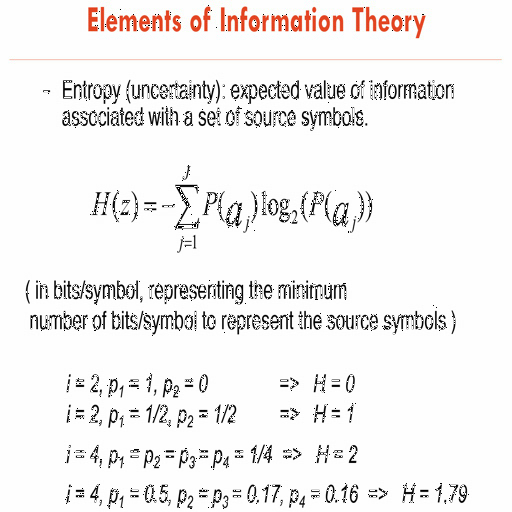

In [ ]:
decode_new('encoded_new1.txt', 'decoded_new1.png', new1_dequantize)

In [ ]:
original_file = 'page.png'
decoded_file = 'decoded_new1.png'

img_ori = Image.open(original_file)
img_doc = Image.open(decoded_file)

img_ori = np.array(img_ori, dtype=np.float32)
img_doc = np.array(img_doc, dtype=np.float32)
print("\n")
print(f'The PSNR of the decoded image {decoded_file} against the original one is {cal_psnr(img_ori, img_doc)}.')
print(f"The SSIM of the decoded image against the original one is {cal_ssim(img_ori,img_doc)}.")
print(f"The compression rate of {decoded_file} is {cal_compression_rate(original_file, decoded_file)}.")



The PSNR of the decoded image decoded_new1.png against the original one is 20.27309022947541.
The SSIM of the decoded image against the original one is 0.8080121674449919.
The compression rate of decoded_new1.png is -39.884919628237355.


Your justification here:  

1. The human eye is more sensitive to low-frequency information in images, so the upper left elements of quantization table keep the low value. This can minimize the perception of the human eye when viewing the image.
At the same time, to ensure the clarity of the characteristics, we also need to control the degree of compression of the high-frequency part of the brightness. this will significantly affect the clarity of the text. Low compression of the high-frequency parts of brightness can prevent text from blurring with images. Increase the recognition of compressed text.
2. When searching for the appropriate quantization table, the method of controlled variables should be employed, where only specific quantization parameters are altered.   
With each change, obtain and compare PSNR and SSIM values to the previous ones. The larger the PSNR and SSIM, the better the quality of the compressed image. The compression ratio after compression should also be compared. Moreover, a subjective visual comparison is necessary to determine if the text has become clearer and the edges sharper.   
Repeat these experiments until an optimal set of quantization table parameters is identified.   
3. According to the code provided, the PSNR is 20.2731, the SSIM is 0.8080, and the compression ratio is -39.88%. Additionally, from a visual perspective, characters can be easily identified by the human eye, and their boundaries are clear. The colors remain unchanged. The downside is that some black dots have appeared on the white background, and the compression ratio is negative.  
Overall, this indicates that the image has achieved a good balance between compression and clarity. This is an ideal quantization table.